Faiss是一个由facebook开发以用于高效相似性搜索和密集向量聚类的库。它能够在任意大小的向量集中进行搜索。它还包含用于评估和参数调整的支持代码。Faiss是用C++编写的，带有Python的完整接口。一些最有用的算法是在GPU上实现的。Faiss官方仓库为:[faiss](https://github.com/facebookresearch/faiss)。

所谓相似性搜索是指通过比较多维空间中数据之间的相似性来搜索与输入数据最相似的目标数据。例如人脸识别中，通过比较人脸向量之前的距离来识别当前人脸与哪张人脸相似。因此，该技术被广泛应用于信息检索、计算机视觉、数据分析等领域。如果要检索的数据很多时，那么就需要一个向量检索库来加速检索。Faiss包含多种相似性搜索方法，并提供cpu和gpu版本支持。Faiss的优势在于通过较小的精度损失提高向量相似度的检索速度和减少内存使用量。本文主要讲述faiss的python3接口使用。faiss官方教程见：[faiss官方教程](https://github.com/facebookresearch/faiss/wiki)。

对于Faiss，linux系统的安装如下：

```
# CPU安装
pip install faiss-cpu
# GPU安装
pip install faiss-gpu
```

windows系统的安装需要conda，安装指令如下。使用前需要conda activate激活环境，不要直接用pip安装。

```
# CPU安装
conda install -c pytorch faiss-cpu

# GPU安装
conda install -c pytorch faiss-gpu
```

# 1 基础使用


## 1.1 入门

**数据库的建立**

Faiss可以处理固定维度的向量集合，这些集合可以存储在矩阵中。Faiss仅使用32位浮点矩阵，其中矩阵的列表示向量的特征，行表示向量样本数。一般来说进行向量检索，我们需要两个矩阵：
+ 索引矩阵，索引矩阵包含所有必须索引的向量，我们将在其中搜索。其维度为[nb向量样本数,d向量维度]。
+ 查询矩阵，查询矩阵。它的大小是[nq向量样本数,d向量维度]。如果我们只有一个查询向量，则nq=1。

下面例子介绍了faiss所需输入矩阵的例子。

In [1]:
import numpy as np
# 向量特征维度
d = 64               
# 索引矩阵向量样本数          
nb = 10000
# 查询矩阵向量样本数                   
nq = 1000        
# 设计随机种子   
np.random.seed(42)             
# 随机生成0到1的数据，简历索引矩阵，但是必须要是float32类型
xb = np.random.random((nb, d)).astype('float32')
# 索引矩阵第一列加上扰动
xb[:, 0] += np.arange(nb) / 1000.
# 建立查询矩阵
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

**建立索引库**

Faiss是围绕索引对象构建的。它会预载索引矩阵，并可选地对其进行预处理以提高搜索效率。索引方式有多种类型，我们将使用最简单的版本，只对其执行最简单的L2距离（欧氏距离）搜索，也就是IndexFlatL2。在预载索引矩阵前，还需要设定向量的维度d，此外大多数索引方式还需要一个训练阶段，以分析向量的分布。对于IndexFlatL2，我们可以跳过此操作，所以L2距离挺慢，属于暴力检索，但是精度高。在faiss中，预载索引矩阵使用add函数，检索查询矩阵用search函数。同时通过is_trained，表示向量是否训练，如果是false就表示需要增加训练向量阶段，通过ntotal表示索引向量的数量。建立索引库的示例如下：

In [2]:
# 加载faiss库
import faiss            
# 设置检索维度       
index = faiss.IndexFlatL2(d)   
# 判断该索引方式是否已经训练，false表示没有训练
print(index.is_trained)
# 添加索引库
index.add(xb)    
# 打印待索引向量数     
print(index.ntotal)

True
10000


**向量检索**

对索引执行的基本搜索操作是k近邻搜索，即对于每个查询向量，在数据库中查找其k个相似向量。faiss中使用search进行查询，search函数返回两个unumpy结构矩阵：

+ 检索距离矩阵D，维度为[nq查询向量样本数，k相似向量数]。其中列表示与k个相似向量的距离，距离从近到远排序。
+ 检索结果距离I，维度为[nq查询向量样本数，k相似向量数]。其中列表示索引库中k个相似向量的id号，相似度从高到低排序。

向量检索的代码如下所示，由于每一个第一个向量的第一个特征都添加了近似于id的值。因此，就查询结果而言，查询向量的相似索引向量id号靠近查询向量的id号。比如第一个查询向量id号为0，其索引向量的id也靠近0。

In [3]:
import time

# 设置查找5个相近向量
k = 5            
# 索引库健全性检查，没出问题表明库加载成功             
D, I = index.search(xb[:5], k)

# 开始时间
start = time.time()
# 实际检索
D, I = index.search(xq, k)    
# 结束时间
end = time.time()
# 这里用的是一台很弱的电脑，速度慢正常。
print("耗时{}s".format(end-start))

# 前五个查询向量的检索结果 
print(I[:5])        
print('---分割线---')
# 最后五个查询向量的检索结果
print(I[-5:])

耗时2.492363214492798s
[[ 234  642  860  369  820]
 [ 145  430   49   27   62]
 [ 200  279  193  331  564]
 [1449  453  515 1173 1502]
 [ 108  442  133 1273  323]]
---分割线---
[[ 842  781 1939 1535 2579]
 [ 321 1591  265 1449  873]
 [1687 1530 1257 1370  942]
 [1403  373 1032  862 1975]
 [ 852  211  673  937  228]]


**上面的程序用numpy直接的计算方式如下，如果维度不高，样本不多，速度要比faiss快。但是如果数据很复杂，以下的程序不要运行，会导致系统崩溃的。**

In [4]:

# 矩阵向量l2距离计算
def dist(xq, xb):
    xq2 = np.sum(xq**2, axis=1, keepdims=True)
    xb2 = np.sum(xb**2, axis=1, keepdims=True)
    xqxb = np.dot(xq,xb.T)
    # faiss在计算l2距离的时候没有开方，加快速度
    # return np.sqrt(xq2 - 2 * xqxb + xb2.T)
    return xq2 - 2 * xqxb + xb2.T

# 获取结果
def get_result(dst,k = 5):
    D = np.sort(dst)[:,:k]
    I = np.argsort(dst)[:,:k]
    return D,I 

# 开始时间
start = time.time()
# dst = dist(xq,xb)
# D_, I_ = get_result(dst,k)
# 结束时间
end = time.time()
# 这里用的是一台很弱的电脑，速度慢正常。
# print("耗时{}s".format(end-start))

# 前五个查询向量的检索结果 
# print(I[:5])        
# print('---分割线---')
# 最后五个查询向量的检索结果
# print(I[-5:])

## 1.2 加快检索速度

前面的代码可以看到，检索速度太慢，尤其是在很弱性能的电脑上。为了加快检索速度，在Faiss中，将数据集分割成若干部分，然后在d维空间中定义了Voronoi单元，每个数据库向量都落在其中一个单元中。这个就是基于Voronoi图的空间最近邻近查询。在搜索时，查询向量先判断落在哪个单元上，然后将其与所在的单元中的索引向量和几个相邻单元的索引向量进行比较。

在Faiss中通过设置IndexIVFFlat索引方式完成，但是这种类型的索引需要一个训练阶段，而且可以在与数据库向量具有相同分布的任何向量集合上执行。IndexIVFFlat还需要另一个索引量化器，通过该量化器将各个索引向量分配给Voronoi单元，这一操作一般通过使用IndexFlatL2来实现。这种方式建库耗时，用于检索的相邻单元数量越少，检索速度越快，精度越低。需要实际情况平衡精度和速度设置用于检索的相邻单元数量。

在IndexIVFFlat搜索方法有两个参数：用于设置单元格数量的nlist，和设置在多少个相近单元进行查找nprobe（默认为一个）。 nprob的增加会导致检索速度线性增加，但是检索精度也会随之上升。一个检索示例如下：

In [5]:
# 单元数
nlist = 100
# 查询向量个数
k = 5
# 设置量化器建立检索空间
quantizer = faiss.IndexFlatL2(d)
# 向量维度，单元数
index = faiss.IndexIVFFlat(quantizer, d, nlist)
# 检索库没有被训练
print(index.is_trained)
# 训练检索库
index.train(xb)
print(index.is_trained)

# 这一操作还是耗时
index.add(xb)             

False
True


**在1个相近单元上进行查找**

可以看到检索速度变快很多，但是精度会下降。但是与前面的L2检索结果不完全相同。这是因为某些结果不在带检索的Voronoi单元中。因此，检索时访问更多的单元可能会被证明是有用的。

In [6]:
# 默认1个相近单元用于查找
print(index.nprobe)
# 开始时间
start = time.time()
D, I = index.search(xq, k) 
# 结束时间
end = time.time()
# 这里用的是一台很弱的电脑，速度慢正常。
print("耗时{}s".format(end-start))
# 前五个向量检索结果
print(I[-5:])

1
耗时0.09508228302001953s
[[ 937 1026  879  461  313]
 [ 321  927  514  581  960]
 [1530 1216 1924 1518 1497]
 [1032 1998 1185 2109 1500]
 [ 211  228  412  267   35]]


**在多个相近单元上进行查找**

In [7]:
# 设置在多少个相近单元进行查找
index.nprobe = 10
# 开始时间
start = time.time()
D, I = index.search(xq, k) 
# 结束时间
end = time.time()
# 这里用的是一台很弱的电脑，速度慢正常。
print("耗时{}s".format(end-start))
# 前五个向量检索结果
print(I[-5:])

耗时0.2911374568939209s
[[ 842  781 1939 1535 1951]
 [ 321  265 1449  873  947]
 [1687 1530 1370  942 1216]
 [1403  373 1032 1975 1411]
 [ 852  211  673  937  228]]


**在所有相近单元上进行查找**

当nprobe=nlist，表示在所有的数据单元上进行查找，这种方式会给出给出与直接L2检索相同的结果，但速度很慢。

In [8]:
# 设置在多少个相近单元进行查找
index.nprobe = nlist
# 开始时间
start = time.time()
D, I = index.search(xq, k) 
# 结束时间
end = time.time()
# 这里用的是一台很弱的电脑，速度慢正常。
print("耗时{}s".format(end-start))
# 前五个向量检索结果
print(I[-5:])

耗时0.5938379764556885s
[[ 842  781 1939 1535 2579]
 [ 321 1591  265 1449  873]
 [1687 1530 1257 1370  942]
 [1403  373 1032  862 1975]
 [ 852  211  673  937  228]]


## 1.3 更低的内存占用

我们看到的索引IndexFlatL2和IndexIVFFlat都存储完整向量。为了扩展到超大数据集，Faiss提供了各种变体，使用基于乘积量化器的有损压缩来压缩存储的向量。向量仍然存储在Voronoi 单元中，但它们的大小减少到可配置的字节数m（特征维度d必须是m的倍数）。

压缩基于乘积量化器，可以看作是额外的量化级别，应用于要编码的向量的子向量。在这种情况下，由于向量没有精确存储，因此搜索方法返回的距离也是近似值。但是这种方法精度不高，而且训练模型时间很长，谨慎使用。

In [9]:
nlist = 100
# 子量化器的数量
m = 8   
k = 4
# 设置量化器建立检索空间
quantizer = faiss.IndexFlatL2(d) 
# 8指定每个子向量编码为8位
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)
index.train(xb)
index.add(xb)
D, I = index.search(xb[:5], k) 
index.nprobe = 10             
# 搜索
D, I = index.search(xq, k)     
print(I[-5:])

[[ 879 1951 1099  895]
 [ 907  906  828 1453]
 [1687 1216 1530 1247]
 [1346 1398 1599 1141]
 [ 673  545  894  267]]


# 2 构建指标

## 2.1 度量指标

Faiss支持两种度量方法，L2（欧式距离）和内积。

+ 对于L2距离，Faiss计算L2距离时没有开平方根，如果需要精确距离，则需要额外的平方根。
+ 对于内积，这一方法是依据余弦相似度。余弦相似度是通过计算两个向量的夹角余弦值来评估它们的相似度，余弦相似度越大，表示向量的夹角越小，那么意味着两个向量越相似。余弦相似度的计算方法为两个向量的内积除以两个向量的模。但是一般情况下，只计算内积而不计算余弦相似度，当两个向量都经过归一化处理，内积计算结果就是余弦相似度。在faiss通过用IndexFlatIP建立内积索引。

直接计算内积，代码如下，精度不高。

In [10]:
# 加载faiss库
import faiss            
# 设置检索维度       
index = faiss.IndexFlatIP(d)   
# 判断该索引方式是否已经训练，false表示没有训练
print(index.is_trained)
# 添加索引库
index.add(xb)    
# 打印待索引向量数     
print(index.ntotal)
import time


# 设置查找5个相近向量
k = 5            
# 索引库健全性检查，没出问题表明库加载成功             
D, I = index.search(xb[:5], k)
# 开始时间
start = time.time()
# 实际检索
D, I = index.search(xq, k)    
# 结束时间
end = time.time()
# 这里用的是一台很弱的电脑，速度慢正常。
print("耗时{}s".format(end-start))

# 前五个查询向量的检索结果，前五个的检索id应该接近0
print(I[:5])        
print(D[:5])        

True
10000
耗时1.2941181659698486s
[[9763 9880 9553 9863 9034]
 [9073 6585 9863 3904 9763]
 [9814 9766 9880 7796 9815]
 [9863 9553 9763 9003 9682]
 [9916 9763 9880 8035 9709]]
[[32.214005 31.82538  31.135605 31.076077 31.035263]
 [20.439157 20.378412 20.31539  20.28349  20.214535]
 [27.588043 27.546564 27.50164  27.338028 27.227661]
 [27.075897 26.859488 26.714897 26.675337 26.580912]
 [27.065765 26.823675 26.782066 26.74991  26.71664 ]]


数据归一化后，计算内积，代码如下。

In [11]:
# 加载faiss库
import faiss            
# 设置检索维度       
index = faiss.IndexFlatIP(d)   
# 判断该索引方式是否已经训练，false表示没有训练
print(index.is_trained)

xb_ = xb.copy()
# 正则化
faiss.normalize_L2(xb_)
# 添加索引库
index.add(xb_)    
# 打印待索引向量数     
print(index.ntotal)
import time


# 设置查找5个相近向量
k = 5            
# 开始时间
start = time.time()
# 实际检索
xq_ = xq.copy()
# 正则化
faiss.normalize_L2(xq_)
D, I = index.search(xq_, k)    
# 结束时间
end = time.time()
# 这里用的是一台很弱的电脑，速度慢正常。
print("耗时{}s".format(end-start))

# 前五个查询向量的检索结果 
print(I[:5])        
print(D[:5])   

True
10000
耗时1.6847233772277832s
[[ 860 1240  234  618  642]
 [ 145  273  348  437  228]
 [1223  200  279  193  605]
 [1502 1449 1696  515 1415]
 [ 442  323  133 1273  108]]
[[0.8677575  0.86685914 0.86608535 0.8649474  0.86269784]
 [0.83961076 0.82170016 0.81780475 0.81556916 0.81182253]
 [0.8426961  0.83725685 0.8371294  0.83701724 0.83649486]
 [0.8574949  0.8456532  0.8434802  0.8426977  0.83955705]
 [0.848532   0.8466242  0.84535056 0.8434353  0.84117293]]


可以numpy直接计算归一化，计算内积，推荐这种方式，代码如下。

In [12]:
# 加载faiss库
import faiss            
# 设置检索维度       
index = faiss.IndexFlatIP(d)   
# 判断该索引方式是否已经训练，false表示没有训练
print(index.is_trained)

# 归一化
xb_ = xb.copy()/np.linalg.norm(xb)
# 正则化
faiss.normalize_L2(xb_)
# 添加索引库
index.add(xb_)    
# 打印待索引向量数     
print(index.ntotal)
import time

# 设置查找5个相近向量
k = 5            
# 开始时间
start = time.time()
# 实际检索
# 归一化
xq_ = xq.copy()/np.linalg.norm(xq)
# 正则化
faiss.normalize_L2(xq_)
D, I = index.search(xq_, k)    
# 结束时间
end = time.time()
# 这里用的是一台很弱的电脑，速度慢正常。
print("耗时{}s".format(end-start))

# 前五个查询向量的检索结果 
print(I[:5])        
print(D[:5]) 

True
10000
耗时1.384207010269165s
[[ 860 1240  234  618  642]
 [ 145  273  348  437  228]
 [1223  200  279  193  605]
 [1502 1449 1696  515 1415]
 [ 442  323  133 1273  108]]
[[0.8677576  0.8668592  0.86608535 0.8649473  0.8626978 ]
 [0.83961076 0.8217001  0.8178047  0.8155691  0.8118226 ]
 [0.8426961  0.83725685 0.8371294  0.83701736 0.836495  ]
 [0.8574948  0.8456532  0.8434803  0.8426978  0.839557  ]
 [0.8485321  0.8466241  0.84535056 0.8434351  0.84117293]]


此外还有一种常用的距离：马氏距离Mahalanobis，faiss中马氏距离的用法见[mahalnobis_to_L2.ipynb](https://gist.github.com/mdouze/6cc12fa967e5d9911580ef633e559476)。关于马氏距离的说明见[马氏距离(Mahalanobis Distance)](https://zhuanlan.zhihu.com/p/46626607)。

## 2.2 Faiss 构建模块

Faiss 建立在一些具有非常高效实现的基本算法之上：k-means 聚类、PCA、PQ 编码/解码。

**聚类**

Faiss提供了一种高效的k-means实现。如下所示。

In [13]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
# 随机创建数据
# n_features特征维度，n_samples样本数，centers聚类中心也可以理解为label数，cluster每个类别数据的方差，random_state随机种子
data, label = make_blobs(n_features=3, n_samples=1000, centers= 5, cluster_std= 0.5 , random_state = 42)
data = data.astype('float32')

In [14]:
# 查看数据
print(data.shape)
# 查看标签
print(label.shape)

(1000, 3)
(1000,)


In [15]:
# 簇中心
ncentroids = 5
# 迭代次数
niter = 1
verbose = True
d = data.shape[1]
# 创建模型
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
# 训练模型
kmeans.train(data)
D, I = kmeans.index.search(data, 1)
# 精度
sum(label==I.reshape(-1))/len(label)

Clustering 1000 points in 3D to 5 clusters, redo 1 times, 1 iterations
  Preprocessing in 0.00 s


0.6

In [16]:
# sklearn聚类
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# KMeans聚类
model = KMeans(n_clusters=5)
pred = model.fit_predict(data)
# 精度
sum(label==pred)/len(label)

0.6

一般来说当样本维度过高，或数据量大的时候，faiss进行聚类是个很不错的选择。

**降维**

faiss降维主要使用PCA，速度比sklearn快得多。示例代码如下

In [17]:
# 随机创建数据
# n_features特征维度，n_samples样本数，centers聚类中心也可以理解为label数，cluster每个类别数据的方差，random_state随机种子
data, label = make_blobs(n_features = 512, n_samples=1000, centers= 10, cluster_std= 0.5 , random_state = 42)
data = data.astype('float32')

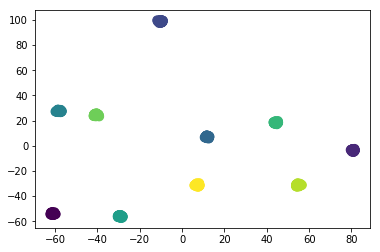

In [18]:
# 降到2维
mat = faiss.PCAMatrix (512, 2)
mat.train(data)
assert mat.is_trained
tr = mat.apply(data)

# 数据可视化
plt.scatter(tr[:, 0], tr[:, 1], s=80,c=label)

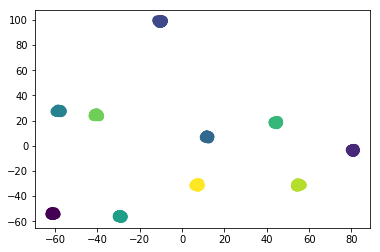

In [19]:
#调用sklearnPCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
tr = pca.fit_transform(data)
# 数据可视化
plt.scatter(tr[:, 0], tr[:, 1], s=80,c=label)

**乘积量化**

有时原始向量维度或向量数太多太高，计算相似度太慢。通过乘积量化对原始向量进行压缩，降低向量维度，压缩数据信息加快检索速度同时节省了内存空间。关于乘积量化见[ANN之乘积量化PQ](https://blog.csdn.net/tiangcs/article/details/124012169)。此外压缩后的数据可以进行恢复为原数据，一般重建误差不高，但建立量化器速度很慢。

In [20]:
# 数据维度
d = 16
# 编码维度
cs = 4 

# 训练数据
nt = 10000
xt = np.random.rand(nt, d).astype('float32')
# 编码数据
n = 5000
x = np.random.rand(n, d).astype('float32')
# 训练量化器
pq = faiss.ProductQuantizer(d, cs, 8)
pq.train(xt)

In [21]:
# 编码
codes = pq.compute_codes(x)
codes.shape
# 解码
x2 = pq.decode(codes)

# 计算重建误差
avg_relative_error = ((x - x2)**2).sum() / (x ** 2).sum()
avg_relative_error

0.016456977

**关于faiss中其他接口的介绍和使用见[Faiss流程与原理分析](https://www.cnblogs.com/yhzhou/p/10568728.html)。**

# 3 参考

+ [faiss](https://github.com/facebookresearch/faiss)
+ [faiss官方教程](https://github.com/facebookresearch/faiss/wiki)
+ [马氏距离(Mahalanobis Distance)](https://zhuanlan.zhihu.com/p/46626607)
+ [mahalnobis_to_L2.ipynb](https://gist.github.com/mdouze/6cc12fa967e5d9911580ef633e559476)
+ [ANN之乘积量化PQ](https://blog.csdn.net/tiangcs/article/details/124012169)
+ [Faiss流程与原理分析](https://www.cnblogs.com/yhzhou/p/10568728.html)